In [101]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
import matplotlib.pyplot as plt
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import json
from datasets import load_dataset
from wordcloud import WordCloud

sns.set(style="whitegrid")

In [102]:
# CSV mit Bert Daten laden
songs_df_bert = pd.read_csv('../src/results/bert/top_songs_bert.csv', encoding='utf-8')
artists_df_bert = pd.read_csv('../src/results/bert/top_artists_bert.csv', encoding='utf-8')

In [103]:
# CSV mit Lexikon Daten laden
songs_df_lexicon = pd.read_csv('../src/results/lexicon/top_songs_lexicon.csv', encoding='utf-8')
artists_df_lexicon = pd.read_csv('../src/results/lexicon/top_astists_lexicon.csv', encoding='utf-8')
top_words_lexicon = pd.read_csv('../src/results/lexicon/top_words_lexicon.csv', encoding='utf-8')

In [104]:
# CSV mit Summen Daten laden
songs_df_intersection = pd.read_csv('../src/results/intersection/top30_songs_overlap.csv', encoding='utf-8')
artists_df_intersection = pd.read_csv('../src/results/intersection/top30_artists_overlap.csv', encoding='utf-8')

In [105]:
# CSV mit allen Resultaten
analysis_results = pd.read_csv('../data/processed/analysis_results.csv', encoding='utf-8')

# VISUALIZATION

## Gesamtverteilung sexistischer vs. nicht-sexistischer Songs & Rapper:innen (Piechart)

Zeigt den prozentualen Anteil sexistischer vs. nicht-sexistischer Songs und Rapper:innen vom Gesamtanteil.

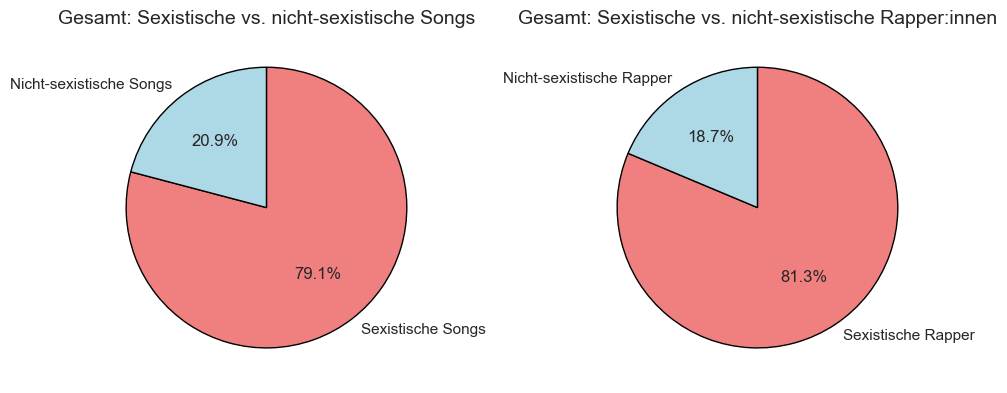

In [217]:
# Gesamtanzahl sexistischer und nicht-sexistischer Songs
total_sexist = analysis_results['is_sexist'].sum()
total_non_sexist = len(analysis_results) - total_sexist

# Anzahl sexistischer vs. nicht-sexistischer Rapper
sexist_rappers = artists_df_bert[artists_df_bert['pct_songs_sexist_weighted'] > 50].shape[0]
non_sexist_rappers = artists_df_bert.shape[0] - sexist_rappers

# Labels und Farben
labels_songs = ['Sexistische Songs', 'Nicht-sexistische Songs']
sizes_songs = [total_sexist, total_non_sexist]

labels_rappers = ['Sexistische Rapper', 'Nicht-sexistische Rapper']
sizes_rappers = [sexist_rappers, non_sexist_rappers]

colors = ['lightcoral', 'lightblue']

# Figure mit zwei Kreisdiagrammen nebeneinander
fig, axes = plt.subplots(1, 2, figsize=(10,10))

# Links: Songs
axes[0].pie(
    sizes_songs,
    labels=labels_songs,
    colors=colors,
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False,
    wedgeprops={'edgecolor': 'black'}
)
axes[0].set_title("Gesamt: Sexistische vs. nicht-sexistische Songs", fontsize=14)

# Rechts: Rapper
axes[1].pie(
    sizes_rappers,
    labels=labels_rappers,
    colors=colors,
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False,
    wedgeprops={'edgecolor': 'black'}
)
axes[1].set_title("Gesamt: Sexistische vs. nicht-sexistische Rapper:innen", fontsize=14)

plt.tight_layout()
# Speichern
plt.savefig("../src/visualization/sexist_songs_rappers_pie.png", dpi=100, bbox_inches='tight')
plt.show()

## Verhältnis sexistische vs. nicht-sexistische Songs pro Jahr nach BERT-Modell

Stellt die jährliche Verteilung sexistischer und nicht-sexistischer Songs laut BERT-Modell dar.

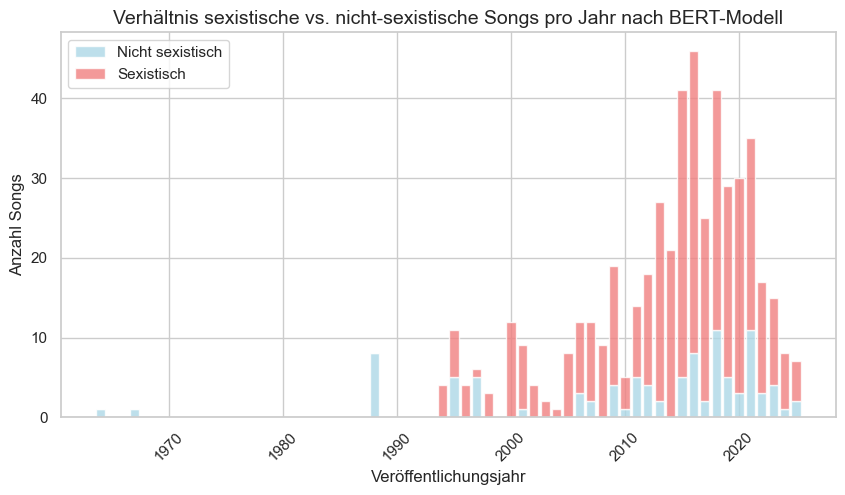

In [218]:
# Release-Datum in echtes Datum umwandeln
analysis_results['release_date'] = pd.to_datetime(analysis_results['release_date'], errors='coerce')

# Nur das Jahr extrahieren
analysis_results['release_year'] = analysis_results['release_date'].dt.year

# Gruppieren nach Jahr
yearly_counts = analysis_results.groupby('release_year').agg(
    total_songs=('song_id', 'count'),
    sexist_songs=('is_sexist', 'sum')
).reset_index()

yearly_counts['non_sexist_songs'] = yearly_counts['total_songs'] - yearly_counts['sexist_songs']
yearly_counts['pct_sexist'] = (yearly_counts['sexist_songs'] / yearly_counts['total_songs']) * 100

# Gestapeltes Balkendiagramm (Sexistisch vs. Nicht-Sexistisch)
plt.figure(figsize=(10,5))
plt.bar(
    yearly_counts['release_year'], 
    yearly_counts['non_sexist_songs'], 
    label="Nicht sexistisch", 
    color="lightblue",
    alpha=0.8
)
plt.bar(
    yearly_counts['release_year'], 
    yearly_counts['sexist_songs'], 
    bottom=yearly_counts['non_sexist_songs'], 
    label="Sexistisch", 
    color="lightcoral",
    alpha=0.8
)
plt.title("Verhältnis sexistische vs. nicht-sexistische Songs pro Jahr nach BERT-Modell", fontsize=14)
plt.xlabel("Veröffentlichungsjahr")
plt.ylabel("Anzahl Songs")
plt.xticks(rotation=45)
plt.legend()
# Speichern
plt.savefig("../src/visualization/sexist_vs_nonsexist_songs_per_year.png", dpi=100, bbox_inches='tight')
plt.show()

## Anteil sexistischer Songs pro Jahr

Zeigt den prozentualen Anteil sexistischer Songs pro Veröffentlichungsjahr.

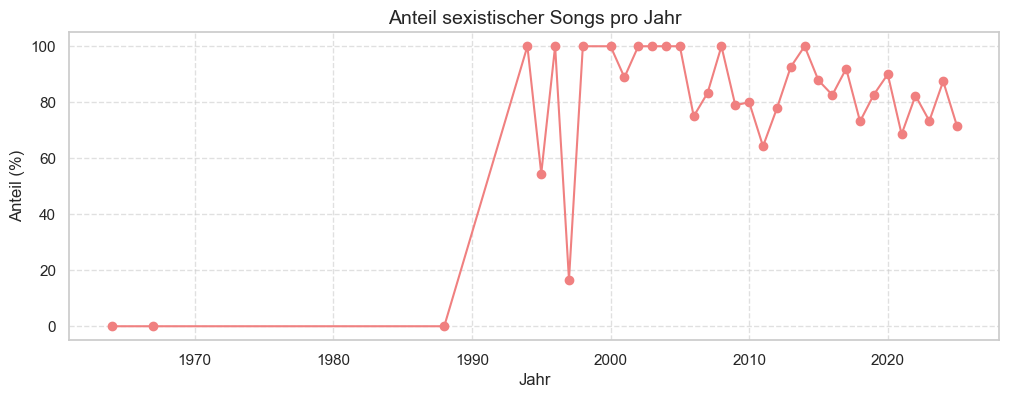

In [219]:
plt.figure(figsize=(12,4))
plt.plot(yearly_counts['release_year'], yearly_counts['pct_sexist'], marker='o', color="lightcoral")
plt.title("Anteil sexistischer Songs pro Jahr", fontsize=14)
plt.xlabel("Jahr")
plt.ylabel("Anteil (%)")
plt.grid(True, linestyle="--", alpha=0.6)
# Speichern
plt.savefig("../src/visualization/pct_sexist_songs_per_year.png", dpi=100, bbox_inches='tight')
plt.show()

## Top 30 sexistischste Rapper:innen

Balkenfarbe:

- Die Farbe wird durch pct_songs_sexist_weighted bestimmt, also die Konsistenz, wie viele Songs eines Künstlers sexistisch sind
- Dunklere Rot-Töne → höhere Konsistenz, d.h. der Künstler hat viele Songs, die sexistisch sind
- Hellere Rot-Töne  → geringere Konsistenz, d.h. der Künstler hat zwar evtl. hohe Durchschnittswerte (avg_sexist_prob), aber nicht alle Songs sind sexistisch

→ Balkenbreite = Intensität (avg_sexist_prob), Balkenfarbe = Konsistenz (% Songs sexistisch)

In [221]:
# Top 30 Rapper aus CSV
top30_artists = artists_df_bert.head(30)

# Farbverlauf nach pct_songs_sexist_weighted (Konsistenz)
norm = plt.Normalize(0.2, top30_artists['pct_songs_sexist_weighted'].max())
colors = plt.cm.Reds(norm(top30_artists['pct_songs_sexist_weighted']))

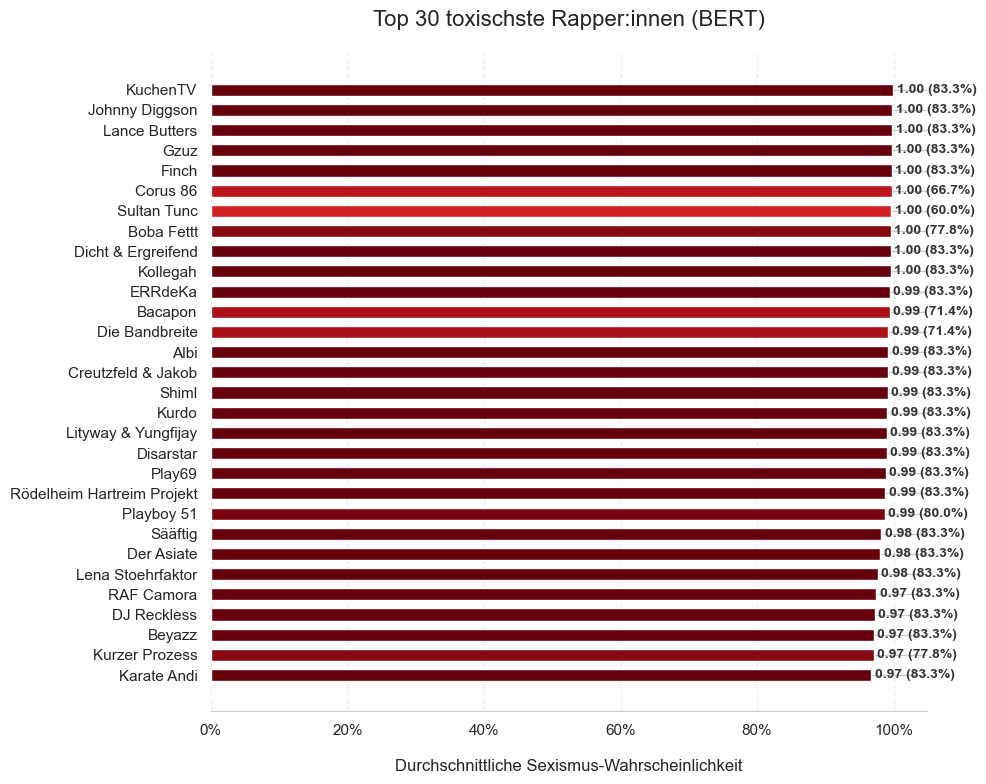

In [222]:
# Y-Positionen
y_pos = np.arange(len(top30_artists))

# Figure erstellen
plt.figure(figsize=(10,8))

# Moderner Balkenplot
bars = plt.barh(
    y=y_pos,
    width=top30_artists['avg_sexist_prob'],
    color=colors,
    edgecolor='white',
    height=0.6
)

# Achsen und Titel
plt.yticks(y_pos, top30_artists['artist_name'], fontsize=11)
plt.xlabel("Durchschnittliche Sexismus-Wahrscheinlichkeit", fontsize=12, labelpad=15)
plt.title("Top 30 toxischste Rapper:innen (BERT)", fontsize=16, pad=20)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))  # x-Achse als Prozent

# Werte direkt auf den Balken anzeigen
for i, row in enumerate(top30_artists.itertuples()):
    plt.text(
        row.avg_sexist_prob + 0.005,
        i,
        f"{row.avg_sexist_prob:.2f} ({row.pct_songs_sexist_weighted:.1f}%)",
        va='center', fontsize=10, fontweight='bold', color='#333333'
    )

# Grid hinter den Balken
plt.grid(axis='x', linestyle='--', alpha=0.4)

# Balkenreihenfolge: größter Wert oben
plt.gca().invert_yaxis()

# Achsenoptik
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_linewidth(0.8)

plt.tight_layout()
# Speichern
plt.savefig("../src/visualization/top30_sexistische_rappers.png", dpi=100, bbox_inches='tight')
plt.show()

## Top-1 sexistischster Song pro Top-30 Rapper:in

Zeigt pro Top-30 Rapper:in den Song mit der höchsten Sexismus-Wahrscheinlichkeit.
Farben und Zahlen geben die Intensität des Sexismus wieder.

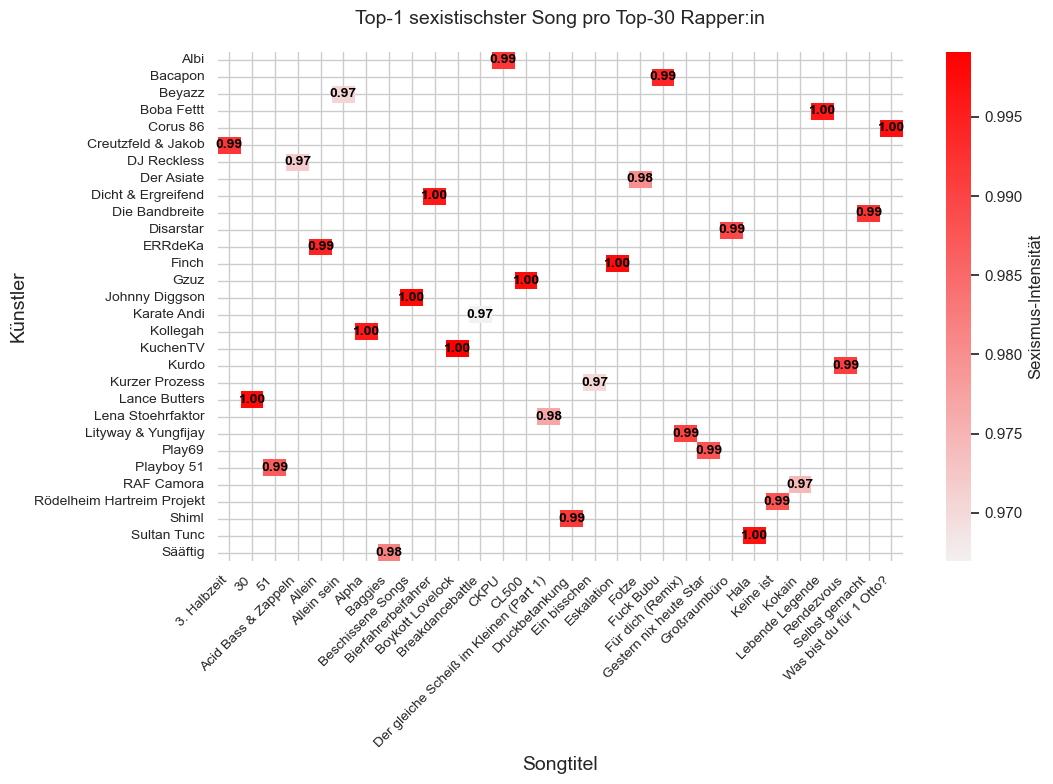

In [223]:
# Top 30 Rapper
top30_artists = artists_df_bert.head(30)

# Top-1 Song pro Künstler aus songs_df_bert
top_songs_per_artist = songs_df_bert[songs_df_bert['artist_name'].isin(top30_artists['artist_name'])]
top1_song = top_songs_per_artist.sort_values('avg_sexist_prob', ascending=False).drop_duplicates('artist_name')

# Pivot für Heatmap: Zeilen = Künstler, Spalten = Songtitel, Werte = avg_sexist_prob
heatmap_data = top1_song.pivot(index='artist_name', columns='song_title', values='avg_sexist_prob')

plt.figure(figsize=(11,8))

# Helleres Rot als Farbpalette
light_red_cmap = sns.light_palette("red", as_cmap=True)

sns.heatmap(
    heatmap_data, 
    annot=True, 
    fmt=".2f", 
    cmap=light_red_cmap, 
    cbar_kws={'label': 'Sexismus-Intensität'},
    annot_kws={"size":10, "weight":"bold", "color":"black"}
)

plt.title("Top-1 sexistischster Song pro Top-30 Rapper:in", fontsize=14, pad=20)
plt.xlabel("Songtitel", fontsize=14)
plt.ylabel("Künstler", fontsize=14)

plt.xticks(fontsize=10, rotation=45, ha="right")
plt.yticks(fontsize=10, rotation=0)

plt.tight_layout()
# Speichern
plt.savefig("../src/visualization/top1_song_per_top30_rapper.png", dpi=100, bbox_inches='tight')
plt.show()

## Konsistenz vs. Intensität sexistischen Sprachgebrauchs

Dieser Plot zeigt die Kombination aus Konsistenz (wie viele Songs) und Intensität (wie heftig die Texte) für jeden Künstler sind.

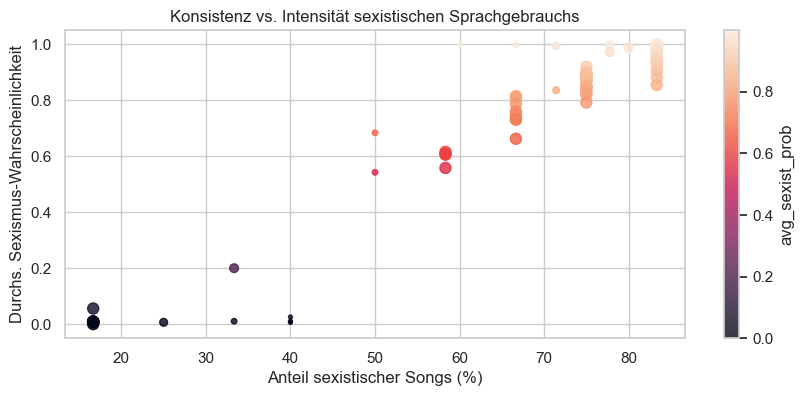

In [224]:
plt.figure(figsize=(10,4))
plt.scatter(
    artists_df_bert['pct_songs_sexist_weighted'], 
    artists_df_bert['avg_sexist_prob'],
    s=artists_df_bert['num_songs_total']*8,  
    alpha=0.8, c=artists_df_bert['avg_sexist_prob']
)
plt.xlabel("Anteil sexistischer Songs (%)")
plt.ylabel("Durchs. Sexismus-Wahrscheinlichkeit")
plt.title("Konsistenz vs. Intensität sexistischen Sprachgebrauchs")
plt.colorbar(label="avg_sexist_prob")
# Speichern
plt.savefig("../src/visualization/consistency_vs_intensity_scatter.png", dpi=100, bbox_inches='tight')
plt.show()

## Top sexistische Begriffe (Lexikon-basiert) im deutschen Hip-Hop

Zeigt die Top-sexistischen Begriffe aus dem Lexikon: 
- Balkenlänge = gewichtete Häufigkeit (Song-Level Sexist-Score)
- Zahl in Klammern = Rohvorkommen
- Dunkleres Rot = stärkeres Vorkommen

C:\Users\emast\AppData\Local\Temp\ipykernel_12080\1009909518.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


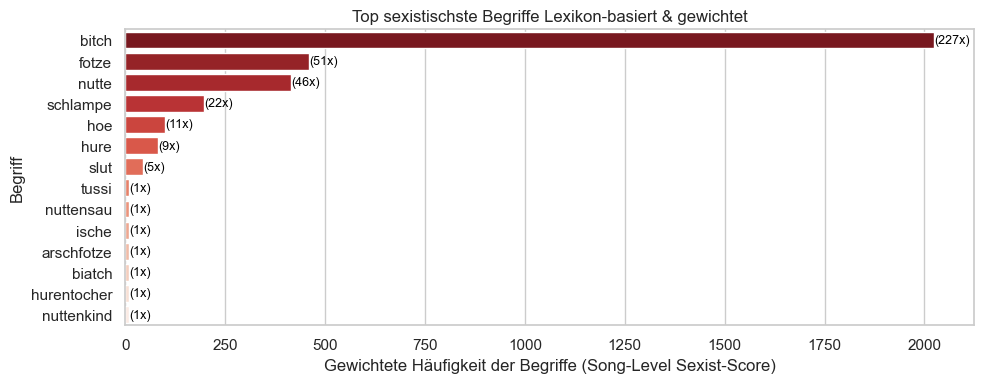

In [225]:
sns.set(style="whitegrid")
plt.figure(figsize=(10,4))
sns.barplot(
    x="weighted_count", 
    y="word", 
    data=top_words_lexicon, 
    palette="Reds_r",
    label="Gewichtet"
)
for i, row in top_words_lexicon.iterrows():
    plt.text(row['weighted_count'] + 0.5, i, f"({row['raw_count']}x)", va='center', fontsize=9, color='black')

plt.xlabel("Gewichtete Häufigkeit der Begriffe (Song-Level Sexist-Score)")
plt.ylabel("Begriff")
plt.title("Top sexistischste Begriffe Lexikon-basiert & gewichtet")
plt.tight_layout()
# Speichern
plt.savefig("../src/visualization/top_sexist_words_lexicon.png", dpi=100, bbox_inches='tight')
plt.show()

# Top 30 Songs & Artists Schnittmenge aus BERT-Modell & Lexicon

Visualisiert, welche Songs und Künstler in beiden Analysen (BERT & Lexikon) gleich gefunden wurden.

In [226]:
# Song-Piechart
songs_intersection = set(songs_df_intersection['Schnittmenge aus Top30 BERT & Lexikon'].dropna())
songs_only_bert  = set(songs_df_intersection['Nur in Top30 BERT'].dropna())
songs_only_lex   = set(songs_df_intersection['Nur in Top30 Lexikon'].dropna())

song_counts = [len(songs_intersection), len(songs_only_bert), len(songs_only_lex)]
labels = ['Schnittmenge', 'BERT-Modell', 'Lexikon']
colors = ['lightgreen','lightblue','lightcoral']

In [227]:
# Künstler-Piechart
artist_intersection = set(artists_df_intersection['Schnittmenge aus Top30 BERT & Lexikon'].dropna())
artists_only_bert  = set(artists_df_intersection['Nur in Top30 BERT'].dropna())
artists_only_lex   = set(artists_df_intersection['Nur in Top30 Lexikon'].dropna())

artist_counts = [len(artist_intersection), len(artists_only_bert), len(artists_only_lex)]

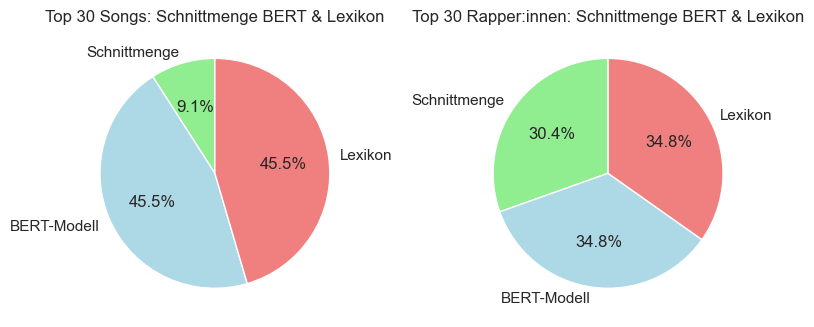

In [228]:
# Piecharts nebeneinander
plt.figure(figsize=(8,4))

# Piechart 1: Songs
plt.subplot(1,2,1)
plt.pie(song_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Top 30 Songs: Schnittmenge BERT & Lexikon')

# Piechart 2: Künstler
plt.subplot(1,2,2)
plt.pie(artist_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Top 30 Rapper:innen: Schnittmenge BERT & Lexikon')

plt.tight_layout()
# Speichern
plt.savefig("../src/visualization/top30_songs_artists_overlap.png", dpi=100, bbox_inches='tight')
plt.show()